# Harmonization
## Erica Simon, 02/02/24
## Purpose: Use the aneris tool to harmonize emisisons datasets
- Historical (1750-2022) and projected (2020-2100) emissions datasets
    - Historical dataset is product of PRIMAP, CEDS, GCP, & GFED. More info in `hist_emis_clean`
    - Projected datasets are outputs of GCAM 6.0 NGFS, MESSAGEix-GLOBIOM, and REMIND-MAgPIE 3.2-4.6. They were last updated in November 2023 and reflect commitments made until March 2023
    
    
Credit: 
- Gidden, M. (2017). gidden/aneris: Initial release version for harmonization paper (v0.1.0). Zenodo. https://doi.org/10.5281/ZENODO.802832
- https://github.com/chrisroadmap/fair-calibrate/blob/main/input/fair-2.1.3/v1.4/all-2022/calibration/12_harmonize-emissions.py


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import aneris
import aneris.convenience
from tqdm.auto import tqdm

import datetime
import os
import warnings

<IPython.core.display.Javascript object>

## Import datasets

In [3]:
GCAM_df = pd.read_csv('~/outputs/GCAM_interp.csv')
MSG_df = pd.read_csv('~/outputs/MSG_interp.csv')
REM_df = pd.read_csv('~/outputs/REM_interp.csv')
hist_df = pd.read_csv('~/outputs/hist_emis_ALL.csv')

## Harmonize
This section of code adapted from https://github.com/chrisroadmap/fair-calibrate/blob/main/input/fair-2.1.3/v1.4/all-2022/calibration/12_harmonize-emissions.py


### set overrides

In [4]:
# Harmonization overrides - use same as RCMIP
overrides = pd.DataFrame(
    [
        {
            "method": "reduce_ratio_2150_cov",
            "variable": "Emissions|C2F6",
        },  # high historical variance (cov=16.2)
        {
            "method": "reduce_ratio_2150_cov",
            "variable": "Emissions|C6F14",
        },  # high historical variance (cov=15.4)
        {
            "method": "reduce_ratio_2150_cov",
            "variable": "Emissions|CF4",
        },  # high historical variance (cov=11.2)
        {
            "method": "reduce_ratio_2150_cov",
            "variable": "Emissions|CO",
        },  # high historical variance (cov=15.4)
        {
            "method": "reduce_ratio_2080",
            "variable": "Emissions|CO2",
        },  # always ratio method by choice
        {
            "method": "reduce_offset_2150_cov",
            "variable": "Emissions|CO2 AFOLU",
        },  # high historical variance, but using offset method to prevent diff from
        # increasing when going negative rapidly (cov=23.2)
        {
            "method": "reduce_ratio_2080",  # always ratio method by choice
            "variable": "Emissions|CO2 FFI",
        },
        #     {'method': 'default_aneris_tree', 'variable': 'Emissions|CH4'},
        # depending on the decision tree in aneris/method.py
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-125",
        },  # minor f-gas with low model reporting confidence
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-134a",
        },  # minor f-gas with low model reporting confidence
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-143a",
        },  # minor f-gas with low model reporting confidence
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-227ea",
        },  # minor f-gas with low model reporting confidence
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-23",
        },  # minor f-gas with low model reporting confidence
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-32",
        },  # minor f-gas with low model reporting confidence
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-4310mee",
        },  # minor f-gas with low model reporting confidence
        #     {'method': 'default_aneris_tree', 'variable': 'Emissions|N2O'},
        # depending on the decision tree in aneris/method.py
        #     {'method': 'default_aneris_tree', 'variable': 'Emissions|NH3'},
        # depending on the decision tree in aneris/method.py
        #     {'method': 'default_aneris_tree', 'variable': 'Emissions|NOx'},
        # depending on the decision tree in aneris/method.py
        {
            "method": "reduce_ratio_2150_cov",
            "variable": "Emissions|OC",
        },  # high historical variance (cov=18.5)
        {
            "method": "constant_ratio",
            "variable": "Emissions|SF6",
        },  # minor f-gas with low model reporting confidence
        #     {'method': 'default_aneris_tree', 'variable': 'Emissions|Sulfur'},
        # depending on the decision tree in aneris/method.py
        {
            "method": "reduce_ratio_2150_cov",
            "variable": "Emissions|VOC",
        },  # high historical variance (cov=12.0)
    ]
)

we need to remove the override for HFC-23 in the MESSAGE IAM because has all emissions at 0 for this specie

In [5]:
MSG_overrides = overrides[~(overrides.variable == 'Emissions|HFC-23')]

### run harmonizer

In [6]:
progress = os.getenv("PROGRESS", "False").lower() in ("true", "1", "t")

In [7]:
def harmonize(hist, future, harm_yr, overrides):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        scenarios_harmonized = [
            aneris.convenience.harmonise_all(
                msdf,
                history=hist,
                year=harm_yr,
                overrides=overrides,
            )
            for _, msdf in tqdm(future.groupby(["Model", "Scenario"]), disable=1 - progress)
        ]

    scenarios_harmonized = pd.concat(scenarios_harmonized).reset_index()
    return scenarios_harmonized

In [8]:
GCAM_harm = harmonize(hist_df, GCAM_df, 2022, overrides)
MSG_harm = harmonize(hist_df, MSG_df, 2022, MSG_overrides)
REM_harm = harmonize(hist_df, REM_df, 2022, overrides)

pyam.core - WARNING: Filtered IamDataFrame is empty!
INFO:root:Harmonizing with reduce_ratio_2080
INFO:root:Harmonizing with reduce_ratio_2150_cov
INFO:root:Harmonizing with reduce_offset_2150_cov
INFO:root:Harmonizing with constant_ratio
pyam.core - WARNING: Filtered IamDataFrame is empty!
INFO:root:Harmonizing with reduce_ratio_2080
INFO:root:Harmonizing with reduce_ratio_2150_cov
INFO:root:Harmonizing with reduce_offset_2150_cov
INFO:root:Harmonizing with constant_ratio
pyam.core - WARNING: Filtered IamDataFrame is empty!
INFO:root:Harmonizing with reduce_ratio_2080
INFO:root:Harmonizing with reduce_ratio_2150_cov
INFO:root:Harmonizing with reduce_offset_2150_cov
INFO:root:Harmonizing with constant_ratio
pyam.core - WARNING: Filtered IamDataFrame is empty!
INFO:root:Harmonizing with reduce_ratio_2080
INFO:root:Harmonizing with reduce_ratio_2150_cov
INFO:root:Harmonizing with reduce_offset_2150_cov
INFO:root:Harmonizing with constant_ratio
pyam.core - WARNING: Filtered IamDataFrame i

### combine hist and future dfs into one harmonized dataset

In [9]:
yrs = np.arange(1750, 2101, 1)
new_column_order = ['model', 'scenario', 'region', 'Variable', 'unit']

for yr in yrs:
    new_column_order.append(str(yr))

In [10]:
def combine(hist_df, future_df):
    # rename to match case of hist df
    future_df = future_df.rename(columns={"variable": "Variable"})
    
    # merge hist and future
    df = pd.merge(future_df, hist_df, on='Variable', how='inner')
    
    # reorder columns to be in correct year order
    df.columns = df.columns.astype(str)
    df.drop(columns=['Model', 'Scenario', 'Region', 'Unit'], inplace=True)  # remove extra columns from hist
    df = df.iloc[:, :-1]  # remove duplicate 2022 column
    df = df[new_column_order]
    
    # update column names for uppercase consistency
    df = df.rename(columns={"model": "Model", "scenario": "Scenario", "region": "Region", "unit": "Unit"})
    
    return df

In [11]:
GCAM_full = combine(hist_df, GCAM_harm)
MSG_full = combine(hist_df, MSG_harm)
REM_full = combine(hist_df, REM_harm)

### save harmonized data

In [12]:
GCAM_full.to_csv('~/outputs/GCAM_harm.csv', index=False)
MSG_full.to_csv('~/outputs/MSG_harm.csv', index=False)
REM_full.to_csv('~/outputs/REM_harm.csv', index=False)

## Visualize

In [40]:
def plot_harm(hist, future, harm_ized, var, scen):
    histt = hist.loc[hist.Variable == 'Emissions|'+var].values[0][255:]
    raw = future.loc[future.Variable == 'Emissions|'+var].loc[future.Scenario == scen].values[0][7:]
    harm = harm_ized.loc[harm_ized.variable == 'Emissions|'+var].loc[harm_ized.scenario == scen].values[0][5:]
    unit = hist.loc[hist.Variable == 'Emissions|'+var].values[0][4]
    mdl = harm_ized.model.values[0]
    
    plt.plot(np.arange(2000, 2023), histt)
    plt.plot(np.arange(2022, 2101), raw, label='unharmonized')
    plt.plot(np.arange(2022, 2101), harm, label='harmonized')
    plt.axvline(2022, linestyle='--', color='grey', alpha=0.5)
    plt.xlabel('Year')
    plt.ylabel(unit)
    plt.title('Harmonized '+var+' Emissions\n'+scen+' Scenario\n'+mdl)
    plt.legend()
    plt.show()

In [14]:
def plot_harm_ax(hist, future, harm_ized, var, scen, ax, maxes):
    histt = hist.loc[hist.Variable == 'Emissions|'+var].values[0][255:]
    raw = future.loc[future.Variable == 'Emissions|'+var].loc[future.Scenario == scen].values[0][7:]
    harm = harm_ized.loc[harm_ized.variable == 'Emissions|'+var].loc[harm_ized.scenario == scen].values[0][5:]
    unit = hist.loc[hist.Variable == 'Emissions|'+var].values[0][4]
    mdl = harm_ized.model.values[0]
    
    # find maximum value on plot
    max_val = max(raw.max(), harm.max())
    maxes.append(max_val)
    
    
    ax.plot(np.arange(2000, 2023), histt)
    ax.plot(np.arange(2022, 2101), raw)
    ax.plot(np.arange(2022, 2101), harm)
    ax.axvline(2022, linestyle='--', color='grey', alpha=0.5)
    # ax.set_ylim(0, 450)
    ax.set_title(mdl)

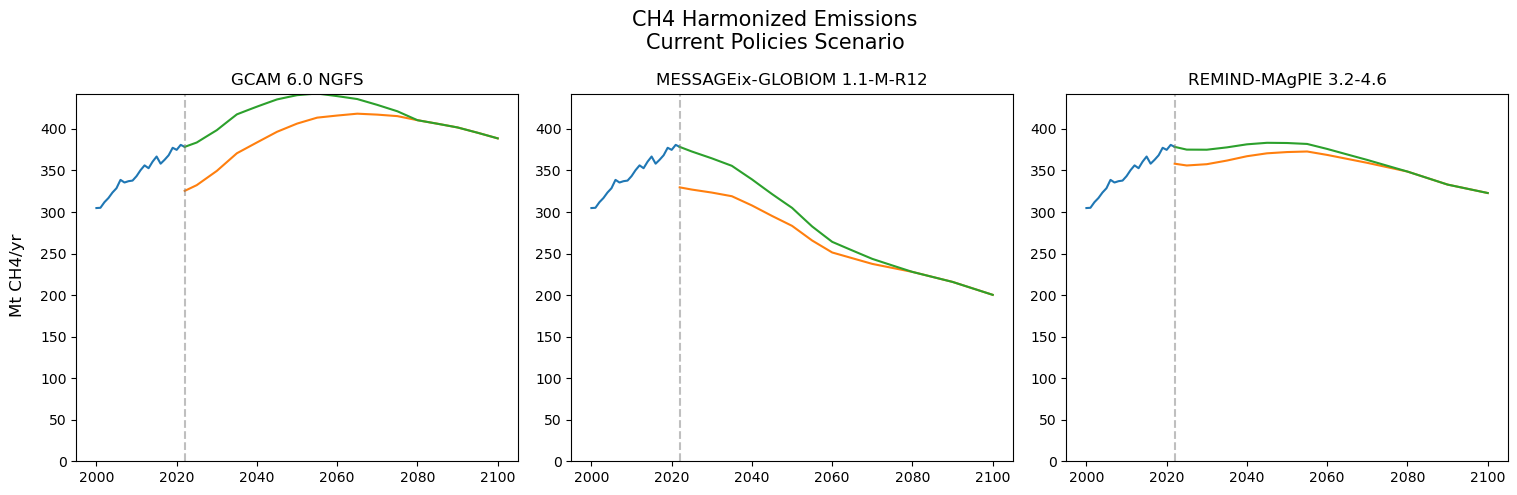

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

maxes = []

for i, (hist, future, harm) in enumerate([(hist_df, GCAM_df, GCAM_harm), (hist_df, MSG_df, MSG_harm), (hist_df, REM_df, REM_harm)]):
    plot_harm_ax(hist, future, harm, 'CH4', 'Current Policies', axs[i], maxes)
    
for i in range (len(axs)):
    axs[i].set_ylim(0, max(maxes))

plt.suptitle('CH4 Harmonized Emissions\nCurrent Policies Scenario', fontsize=15)
fig.text(-0.01, 0.45, 'Mt CH4/yr', va='center', rotation='vertical', fontsize=12)
fig.tight_layout()
plt.show()

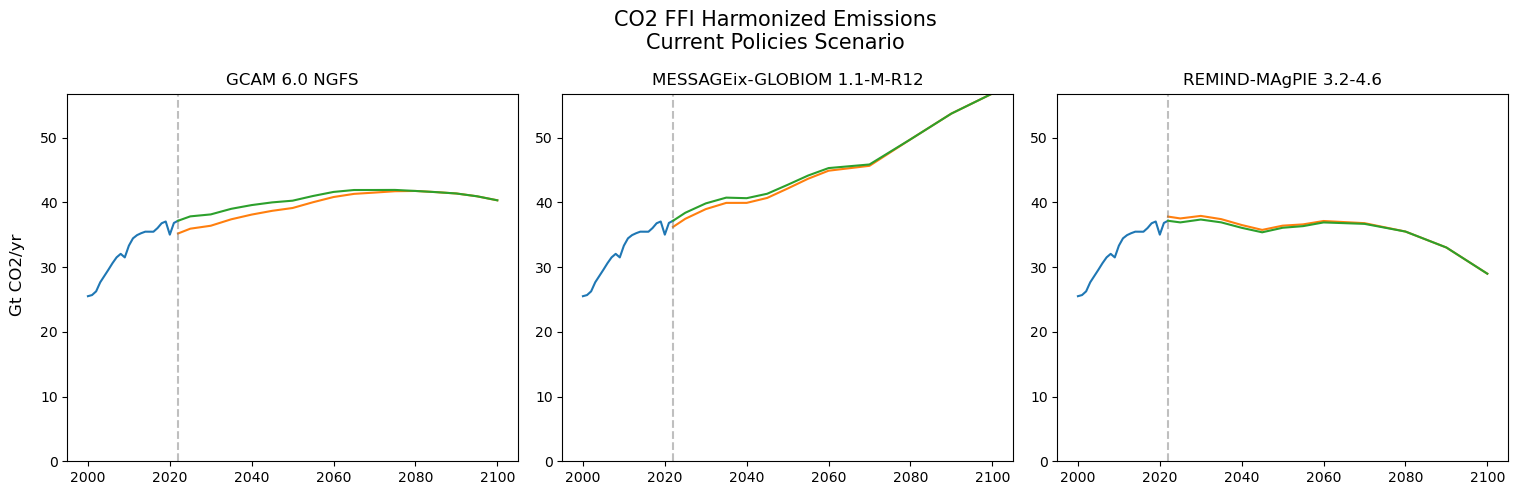

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

maxes = []

for i, (hist, future, harm) in enumerate([(hist_df, GCAM_df, GCAM_harm), (hist_df, MSG_df, MSG_harm), (hist_df, REM_df, REM_harm)]):
    plot_harm_ax(hist, future, harm, 'CO2 FFI', 'Current Policies', axs[i], maxes)

for i in range (len(axs)):
    axs[i].set_ylim(0, max(maxes))

plt.suptitle('CO2 FFI Harmonized Emissions\nCurrent Policies Scenario', fontsize=15)
fig.text(-0.01, 0.45, 'Gt CO2/yr', va='center', rotation='vertical', fontsize=12)
fig.tight_layout()
plt.show()

### check unit adjustment

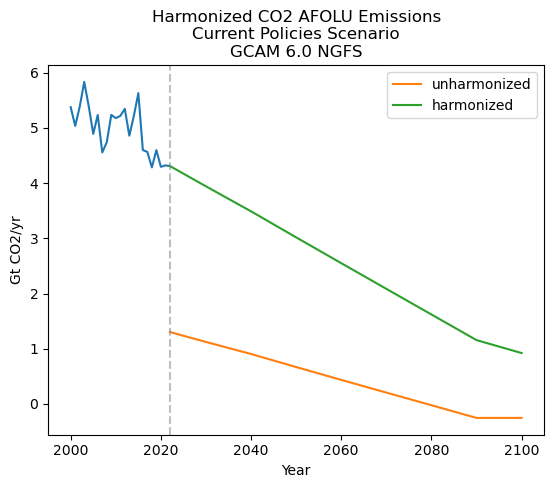

In [17]:
plot_harm(hist_df, GCAM_df, GCAM_harm, 'CO2 AFOLU', 'Current Policies')

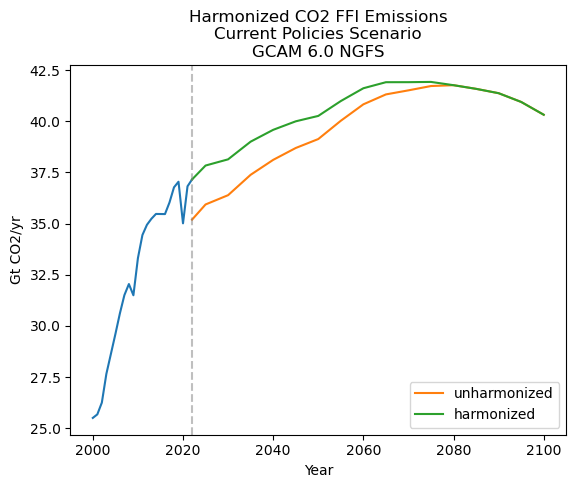

In [18]:
plot_harm(hist_df, GCAM_df, GCAM_harm, 'CO2 FFI', 'Current Policies')

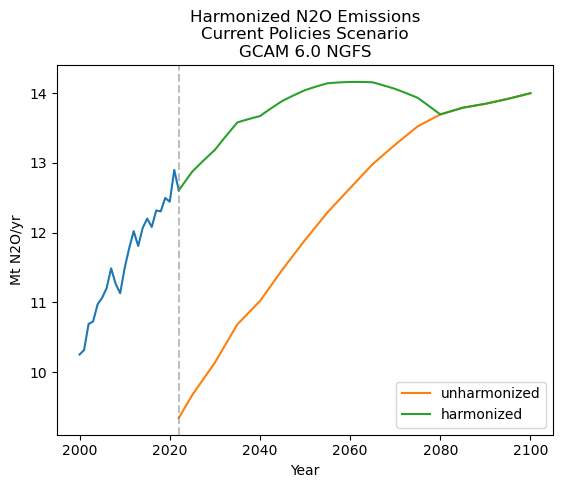

In [19]:
plot_harm(hist_df, GCAM_df, GCAM_harm, 'N2O', 'Current Policies')

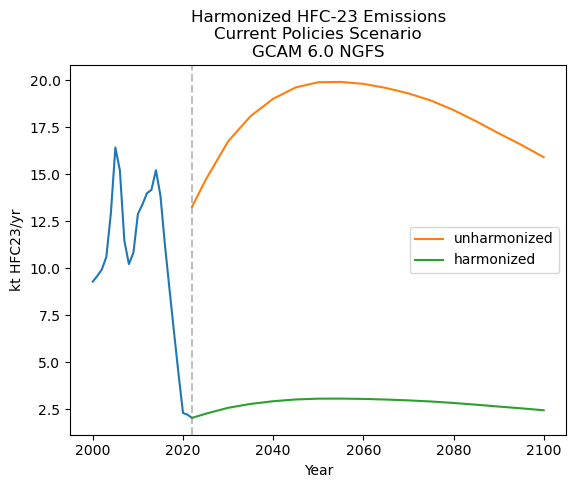

In [20]:
plot_harm(hist_df, GCAM_df, GCAM_harm, 'HFC-23', 'Current Policies')

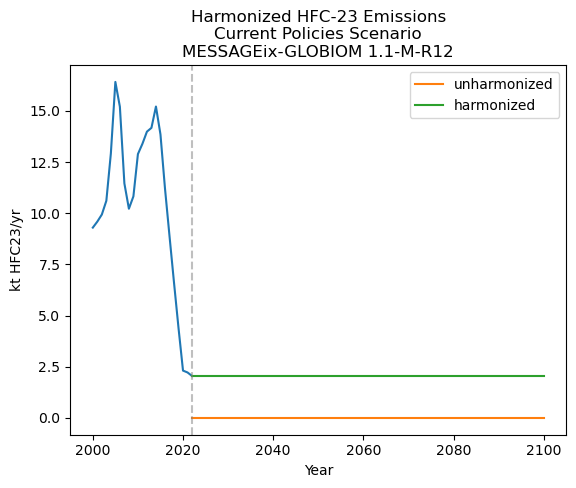

In [21]:
plot_harm(hist_df, MSG_df, MSG_harm, 'HFC-23', 'Current Policies')

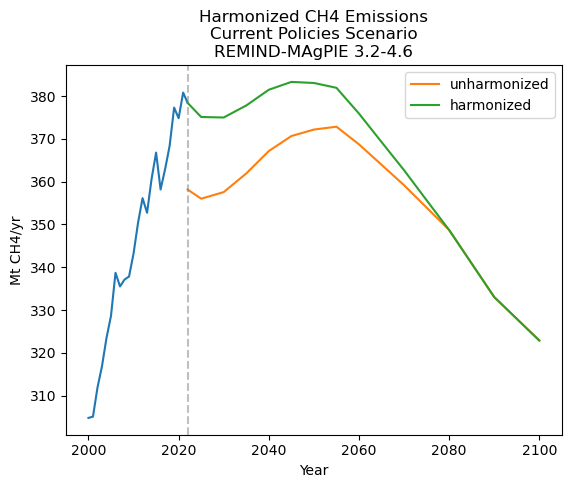

In [22]:
plot_harm(hist_df, REM_df, REM_harm, 'CH4', 'Current Policies')

# Harmonize for Infilling

### imports

In [23]:
GCAM_i = pd.read_csv('~/outputs/GCAM_infilled.csv')
MSG_i = pd.read_csv('~/outputs/MSG_infilled.csv')
REM_i = pd.read_csv('~/outputs/REM_infilled.csv')

### run harmonizer

In [28]:
GCAM_harm_i = harmonize(hist_df, GCAM_i, 2022, overrides)
MSG_harm_i = harmonize(hist_df, MSG_i, 2022, MSG_overrides)
REM_harm_i = harmonize(hist_df, REM_i, 2022, overrides)

pyam.core - WARNING: Filtered IamDataFrame is empty!
INFO:root:Harmonizing with reduce_ratio_2080
INFO:root:Harmonizing with reduce_ratio_2150_cov
INFO:root:Harmonizing with reduce_offset_2150_cov
INFO:root:Harmonizing with constant_ratio
pyam.core - WARNING: Filtered IamDataFrame is empty!
INFO:root:Harmonizing with reduce_ratio_2080
INFO:root:Harmonizing with reduce_ratio_2150_cov
INFO:root:Harmonizing with reduce_offset_2150_cov
INFO:root:Harmonizing with constant_ratio
pyam.core - WARNING: Filtered IamDataFrame is empty!
INFO:root:Harmonizing with reduce_ratio_2080
INFO:root:Harmonizing with reduce_ratio_2150_cov
INFO:root:Harmonizing with reduce_offset_2150_cov
INFO:root:Harmonizing with constant_ratio
pyam.core - WARNING: Filtered IamDataFrame is empty!
INFO:root:Harmonizing with reduce_ratio_2080
INFO:root:Harmonizing with reduce_ratio_2150_cov
INFO:root:Harmonizing with reduce_offset_2150_cov
INFO:root:Harmonizing with constant_ratio
pyam.core - WARNING: Filtered IamDataFrame i

### combine hist and future dfs into one harmonized dataset

In [29]:
GCAM_full_i = combine(hist_df, GCAM_harm_i)
MSG_full_i = combine(hist_df, MSG_harm_i)
REM_full_i = combine(hist_df, REM_harm_i)

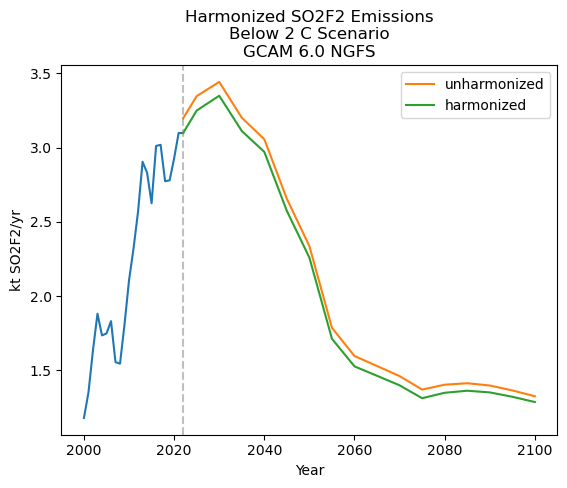

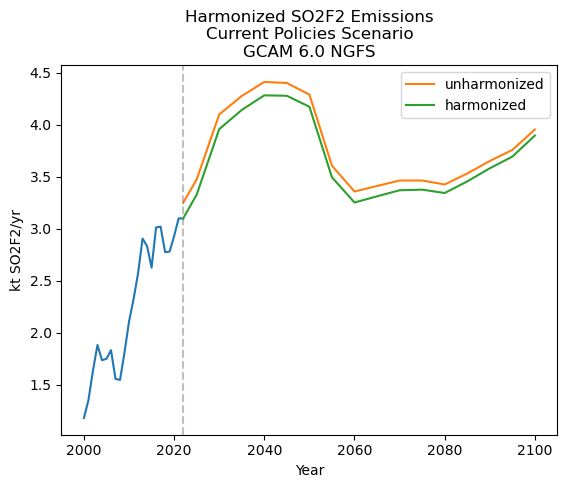

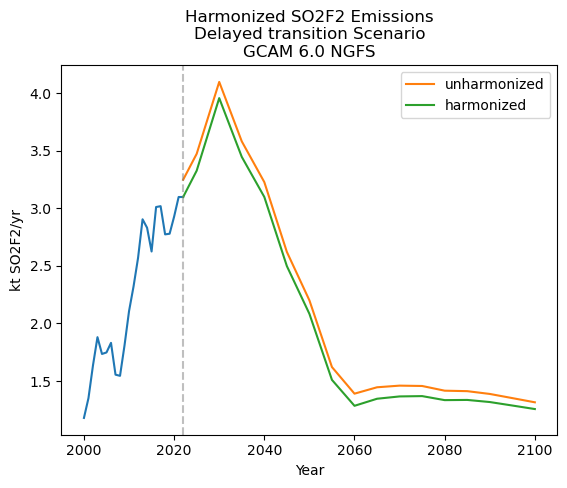

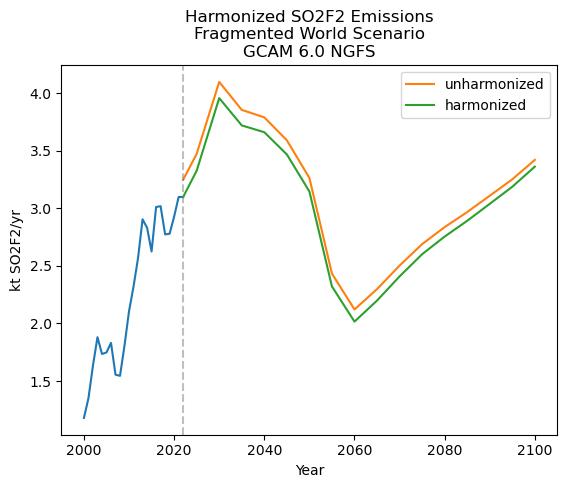

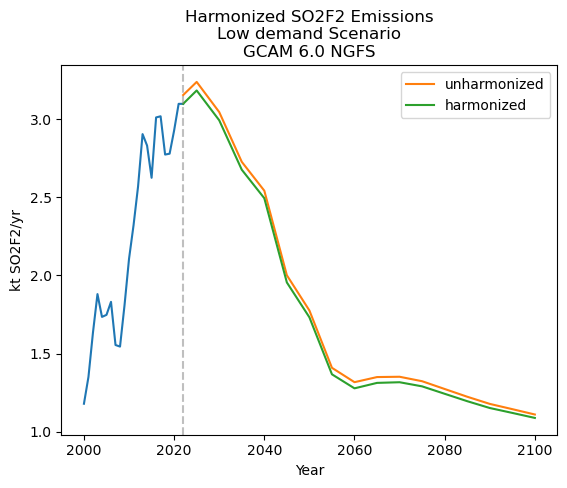

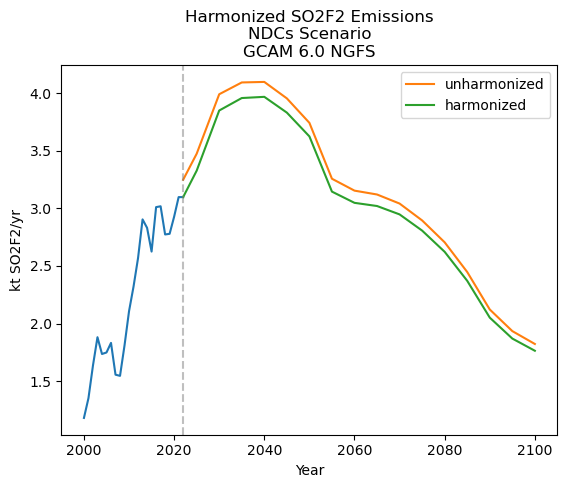

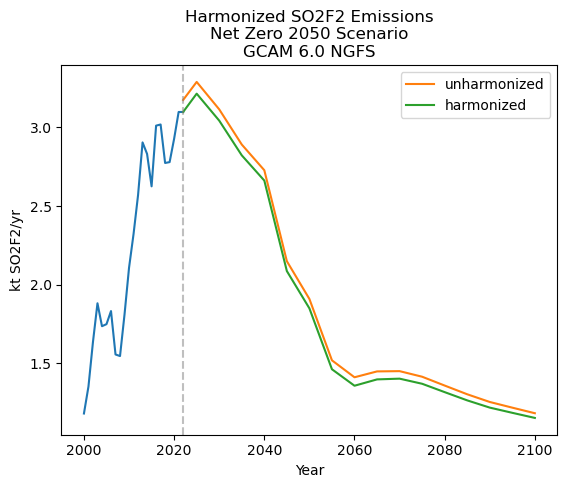

In [47]:
for scen in GCAM_i.Scenario.unique():
    plot_harm(hist_df, GCAM_i, GCAM_harm_i, 'SO2F2', scen)

### add historical values of missing species
missing emissions data (2022-2100) is infilled 'blank' with `NaN`

it will be properly infilled using Silicone tool in `silicone.ipynb`

In [30]:
# def blank_infill(missing_vars, harm_df):
#     with warnings.catch_warnings():
#         warnings.simplefilter(action='ignore', category=FutureWarning)

#         for var in missing_vars:
#             for scen in harm_df.Scenario.unique():
#                 mdl = harm_df.Model.values[0]
#                 rest = hist_df.loc[hist_df.Variable == var].values[0][2:]

#                 all_list = [mdl, scen, rest]
#                 all_list.extend(all_list.pop())

#                 new_row = pd.Series(index=harm_df.columns)
#                 new_row.iloc[:len(all_list)] = all_list
#                 harm_df = pd.concat([harm_df, new_row.to_frame().T], ignore_index=True)
#     return harm_df

In [31]:
# GCAM_missing = np.setdiff1d(hist_df['Variable'].unique(), GCAM_full_i['Variable'].unique())
# MSG_missing = np.setdiff1d(hist_df['Variable'].unique(), MSG_full_i['Variable'].unique())
# REM_missing = np.setdiff1d(hist_df['Variable'].unique(), REM_full_i['Variable'].unique())

In [32]:
# GCAM_full_i = blank_infill(GCAM_missing, GCAM_full_i)
# MSG_full_i = blank_infill(MSG_missing, MSG_full_i)
# REM_full_i = blank_infill(REM_missing, REM_full_i)

### save harmonized data

In [29]:
GCAM_full_i.to_csv('~/outputs/GCAM_infilling2.csv', index=False)
MSG_full_i.to_csv('~/outputs/MSG_infilling2.csv', index=False)
REM_full_i.to_csv('~/outputs/REM_infilling2.csv', index=False)